# Introducing the Semantic Graph

One of the main use cases of txtai is semantic search over a corpus of data. Semantic search provides an understanding of natural language and identifies results that have the same meaning, not necessarily the same keywords. Within an Embeddings instance sits a wealth of implied knowledge and relationships between rows. Many approximate nearest neighbor (ANN) indexes are even backed by graphs. What if we are able to tap into this knowledge?

Semantic graphs, also known as knowledge graphs or semantic networks, build a graph network with semantic relationships connecting the nodes. In txtai, they can take advantage of the relationships inherently learned within an embeddings index. This opens exciting possibilities for exploring relationships, such as topics and interconnections in a dataset. 

This notebook introduces the semantic graph.



# Install dependencies

Install `txtai` and all dependencies. We'll install the graph extra for graph functionality, pipeline extra for object detection and similarity extra to load models with the sentence-transformers library.

In [ ]:
%%capture
!pip install git+https://github.com/neuml/txtai#egg=txtai[graph,pipeline,similarity] datasets ipyplot

# Graph basics

First we'll build a basic [graph](https://en.wikipedia.org/wiki/Graph_theory) and show how it can be used to explore relationships.

The code below builds a graph of animals and relationships between them. We'll add nodes and relationships along with running a couple analysis functions.

Centrality: {'wolf': 0.75, 'dog': 0.5, 'fox': 0.5, 'zebra': 0.5, 'horse': 0.25}
Path (dog->horse): dog -> wolf -> zebra -> horse


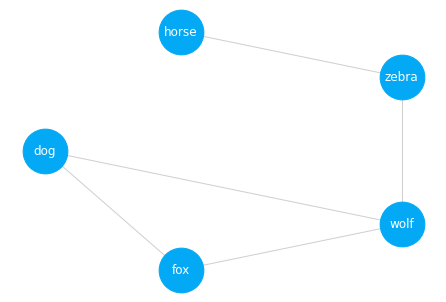

In [ ]:
import networkx as nx

from txtai.graph import GraphFactory

# Create graph
graph = GraphFactory.create({"backend": "networkx"})
graph.initialize()

# Add nodes
nodes = [(0, "dog"), (1, "fox"), (2, "wolf"), (3, "zebra"), (4, "horse")]
labels = {uid:text for uid, text in nodes}
for uid, text in nodes:
  graph.addnode(uid, text=text)

# Add relationships
edges = [(0, 1, 1), (0, 2, 1), (1, 2, 1), (2, 3, 0.25), (3, 4, 1)]
for source, target, weight in edges:
  graph.addedge(source, target, weight=weight)

# Print centrality and path between 0 and 4
print("Centrality:", {labels[k]:v for k, v in graph.centrality().items()})
print("Path (dog->horse):", " -> ".join([labels[uid] for uid in graph.showpath(0, 4)]))

# Visualize graph
nx.draw(graph.backend, nx.shell_layout(graph.backend), labels=labels, with_labels=True,
        node_size=2000, node_color="#03a9f4", edge_color="#cfcfcf", font_color="#fff")

The visualization shows the layout of the graph. A centrality and path function were also run. Centrality shows the most central or related nodes. In this case, the `wolf` node has the highest score. We also ran a path function to show how the graph is traversed from `dog` to `horse`.

# Build a Semantic Graph

While txtai graphs can be standalone, with nodes and relationships manually added, the real power comes in indexing an embeddings instance.

The following section builds an embeddings index over the `ag_news` dataset. `ag_news` contains news headlines from the mid 2000s. This configuration sets the familiar vector model and content settings.

Column expressions is a feature starting with txtai 5.0. Column expressions alias expressions allowing SQL statements to use those references as a shorthand for the expression.

Next comes the graph. The configuration sets the maximum number of connections to add per node (15) along with a minimum similarity score (0.1). Topic modeling parameters are also added which we'll cover later.

In [ ]:
from datasets import load_dataset

from txtai.embeddings import Embeddings

# Create embeddings instance with a semantic graph
embeddings = Embeddings({
  "path": "sentence-transformers/all-MiniLM-L6-v2",
  "content": True,
  "functions": [
    {"name": "graph", "function": "graph.attribute"},
  ],
  "expressions": [
      {"name": "category", "expression": "graph(indexid, 'category')"},
      {"name": "topic", "expression": "graph(indexid, 'topic')"},
      {"name": "topicrank", "expression": "graph(indexid, 'topicrank')"}
  ],
  "graph": {
      "limit": 15,
      "minscore": 0.1,
      "topics": {
          "categories": ["Society & Culture", "Science & Mathematics", "Health", "Education & Reference", "Computers & Internet", "Sports",
                         "Business & Finance", "Entertainment & Music", "Family & Relationships", "Politics & Government"]
      }
  }
})

# Load dataset
dataset = load_dataset("ag_news", split="train")
rows = dataset["text"]

In [ ]:
# Index dataset
embeddings.index((x, text, None) for x, text in enumerate(rows))

The embeddings index is now created. Let's explore!

# Topic modeling

[Topic modeling](https://en.wikipedia.org/wiki/Topic_model) is an unsupervised method to identify abstract topics within a dataset. The most common way to do topic modeling is to use clustering algorithms to group nodes with the closest proximity.

A number of excellent topic modeling libraries exist in Python today. [BERTopic](https://github.com/MaartenGr/BERTopic) and [Top2Vec](https://github.com/ddangelov/Top2Vec) are two of the most popular. Both use [sentence-transformers](https://github.com/UKPLab/sentence-transformers) to encode data into vectors, [UMAP](https://github.com/lmcinnes/umap) for dimensionality reduction and [HDBSCAN](https://github.com/scikit-learn-contrib/hdbscan) to cluster nodes.

Given that an embeddings index has already encoded and indexed data, we'll take a different approach. txtai builds a graph running a query for each node against the index. In addition to topic modeling, this also opens up much more functionality which will be covered later.

Topic modeling in txtai is done using [community detection](https://en.wikipedia.org/wiki/Community_structure) algorithms. Similar nodes are group together. There are settings to control how much granularity is used to group nodes. In other words, topics can be very specific or broad, depending on these settings. Topics are labeled by building a BM25 index over each topic and finding the most common terms associated with the topic.

Let's take a closer look at the topics created with this embeddings index.

In [ ]:
# Store reference to graph
graph = embeddings.graph
len(embeddings.graph.topics)

1919

In [ ]:
list(graph.topics.keys())[:5]

['kerry_john_bush_president',
 'sox_red_boston_series',
 'oil_opec_prices_said',
 'dollar_reuters_against_euro',
 'darfur_sudan_region_said']

The section above shows the number of topics in the index and top 5 topics. Keep in mind that `ag_news` is from the mid 2000s and that is evident with the top topics.

Given that we added functions to run SQL functions to get the topic for each row, we can use that to explore topics.

Each topic is associated with a list of associated matching ids. Those ids are ranked based on the importance to the topic in a field named `topicrank`. The section below prints the best matching text for the topic `sox_red_boston_series`. 

In [ ]:
print(embeddings.search("select text from txtai where topic = 'sox_red_boston_series' and topicrank = 0", 1)[0]["text"])

Red Sox heading to the World Series The Boston Red Sox have won the American League Championship Series and are heading to the World Series for the first time since 1986.


In addition to topics, higher level categories can be associated with topics. This enables having granular topics and encompassing categories for topics. For example, the topic of 'sox_red_boston_series' has a category of `Sports`. See below.

In [ ]:
for x, topic in enumerate(list(graph.topics.keys())[:5]):
  print(graph.categories[x], topic)

Politics & Government kerry_john_bush_president
Sports sox_red_boston_series
Business & Finance oil_opec_prices_said
Business & Finance dollar_reuters_against_euro
Politics & Government darfur_sudan_region_said


Topics and categories can also be used to filter results. See the difference when just querying for results similar to `book` and similar to `book` with a topic of `Sports`.

In [ ]:
print(embeddings.search("select text from txtai where similar('book')", 1)[0]["text"])

A Guidebook for Every Taste LANNING a trip involves many difficult decisions, but near the top of my list is standing in a bookstore trying to choose from a daunting lineup of guidebooks, a purchase that brands the owner 


In [ ]:
print(embeddings.search("select text from txtai where category='Sports' and similar('book')", 1)[0]["text"])

Same story for Wildcats After a game about as artful as a dime-store novel, Virginia coach Pete Gillen turned to literature to express the trying time his No.


# Graph analysis

Indexing an embeddings instance into a graph adds the ability to do network analysis. For example, the centrality of the graph can be analyzed to find the most common nodes. Alternatively, pagerank could also be run to rank the importance of nodes within the dataset. 

The section below runs graph centrality and shows the associated topic for the most central nodes. Not surprisingly, many of the topics are top topics.

In [ ]:
centrality = graph.centrality()

topics = list(graph.topics.keys())

for uid in list(centrality.keys())[:5]:
  topic = graph.attribute(uid, "topic")
  print(f"{topic} ({topics.index(topic)})")

peoplesoft_oracle_takeover_bid (442)
darfur_sudan_region_said (4)
windows_microsoft_xp_service (12)
fallujah_us_city_iraqi (24)
eclipse_lunar_moon_total (615)


# Walk the graph

Given that graphs are nodes and relationships, we can traverse the nodes using those relationships. The graph can be used to show how any two nodes are connected. 

In [ ]:
from IPython.display import HTML

def highlight(index, result):
  output = f"{index}. "
  spans = [(token, score, "#fff59d" if score > 0.025 else None) for token, score in result["tokens"]]

  if result["score"] >= 0.05 and not [color for _, _, color in spans if color]:
    mscore = max([score for _, score, _ in spans])
    spans = [(token, score, "#fff59d" if score == mscore else color) for token, score, color in spans]

  for token, _, color in spans:
    output += f"<span style='background-color: {color}'>{token}</span> " if color else f"{token} "

  return output

def showpath(source, target):
  path = graph.showpath(source, target)
  path = [graph.attribute(p, "text") for p in path]

  sections = []
  for x, p in enumerate(path):
      if x == 0:
          # Print start node
          sections.append(f"{x + 1}. {p}")

      if x < len(path) - 1:
          # Explain and highlight next path element
          results = embeddings.explain(p, [path[x + 1]], limit=1)[0]

          sections.append(highlight(x + 2, results))

  return HTML("<br/><br/>".join(sections))

In [ ]:
showpath(82889, 67364)

This shows how text about a `famous squirrel` and the `Red Sox winning the world series` are connected. Notice how the first match pivots to a node about a squirrel running on the field during a baseball game. From there, it's a relatively logical path to the end node. 

This is reminiscent of the game "six degrees of Kevin Bacon". Try running `showpath` with calls to `random.randint(0, len(rows) - 1)`, it's oddly addicting. This is a fun way to explore the interconnectivity of a dataset.

# Group images into topics

Topic modeling isn't limited to text. It supports any data that can be vectorized into an embeddings index. Next we'll create an embeddings index using the `imagenette` dataset, which is a small dataset for image object detection

In [ ]:
dataset = load_dataset("frgfm/imagenette", "160px", split="train")
rows = dataset["image"]

# Index with content and objects
embeddings = Embeddings({
  "method": "sentence-transformers",
  "path": "sentence-transformers/clip-ViT-B-32",
  "content": True,
  "objects": "image",
  "functions": [
      {"name": "graph", "function": "graph.attribute"},
  ],
  "expressions": [
      {"name": "topic", "expression": "graph(indexid, 'topic')"},
      {"name": "topicrank", "expression": "graph(indexid, 'topicrank')"}
  ],
  "graph": {
      "limit": 15,
      "minscore": 0.1,
      "topics": {
          "resolution": 1.0
      }
  }
})

embeddings.index((x, image, None) for x, image in enumerate(rows))

In [ ]:
graph = embeddings.graph
list(graph.topics.keys())[:5]

['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4']

# Topic labeling for images

The index is now ready. Notice how the topic names are generic. Given there is no text associated, a different approach is needed. We'll use an object detection pipeline to label to best matching image per topic.

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 5dca96d (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.



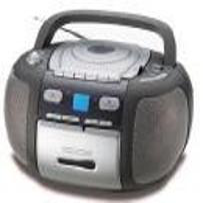
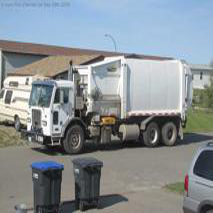
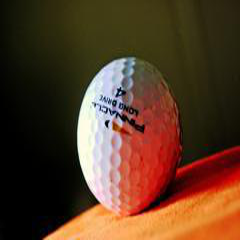
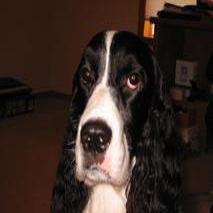
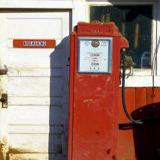


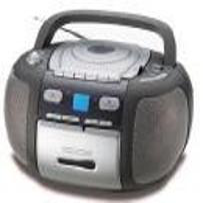
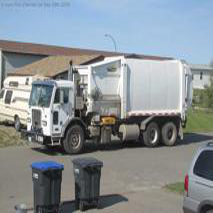
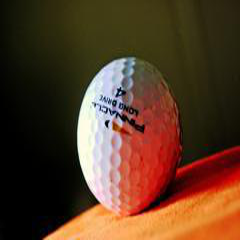
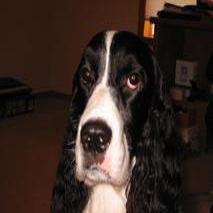
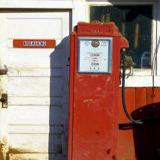

In [ ]:
import ipyplot

from PIL import Image

from txtai.pipeline import Objects

def labels():
  objects = Objects(classification=True, threshold=0.25)

  images = embeddings.search("select topic, object from txtai where topicrank=0 order by topic", 100)
  results = objects([result["object"] for result in images], flatten=True)

  return {images["topic"]: results[x][0].split(",")[0] for x, images in enumerate(images)}

def scale(image, factor=1):
  width, height = image.size
  return image.resize((int(width / factor), int((width / factor))))

images, labels = {}, labels()

for topic in list(graph.topics.keys())[:5]:
  for result in embeddings.search(f"select topic, object from txtai where topic = '{topic}' and topicrank = 0", len(graph.topics)):
    images[topic] = scale(result["object"])

ipyplot.plot_images(list(images.values()), [labels[topic] for topic in images], img_width=150)

As we can see, each topic is now labeled. Imagenette is a labeled dataset, let's evaluate the accuracy of our topic modeling.

In [ ]:
def accuracy():
  correct, total = 0, 0
  labels = dataset["label"]

  for topic in graph.topics:
      label = labels[int(graph.topics[topic][0])]
      correct += sum(1 if labels[int(x)] == label else 0 for x in graph.topics[topic])
      total += len(graph.topics[topic])

  print("Accuracy:", correct/total)

accuracy()

Accuracy: 0.9747597423170345


Not bad, 97.48% accuracy using a totally unsupervised method not even intended for image classification!

# Walk the image graph

As we did before, let's walk the graph. We'll start with two images, `a person parachuting from the sky` and `someone holding a french horn`.


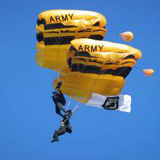
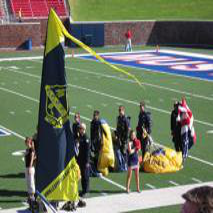
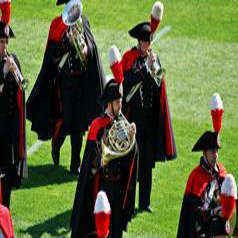
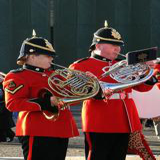
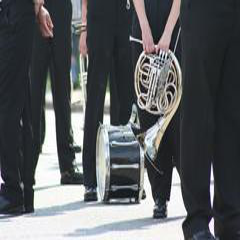


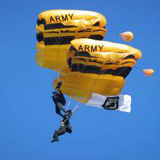
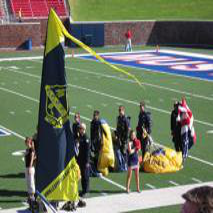
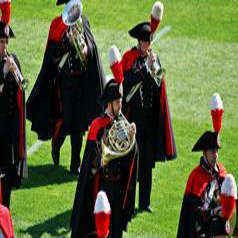
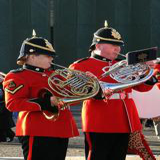
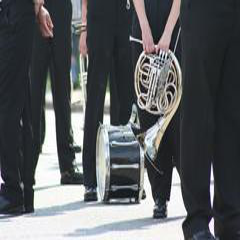

In [ ]:
images = []
for uid in graph.showpath(4352, 9111):
  images.append(scale(embeddings.search(f"select object from txtai where indexid = {uid} limit 1")[0]["object"]))

ipyplot.plot_images(images, img_width=150)

Very interesting! The first match is a person parachuting onto a football field, followed by a matching band on a field, finally leading to a person holding a french horn.

# Wrapping up

This notebook covered quite a lot! We introduced graphs, showed how they can be used to model semantic relationships and topics. This change makes it easier to run exploratory data analysis on a dataset with txtai and quickly gain insights. 

This is just the beginning of what is possible and there are a wide range of exciting new possibilities for txtai, stay tuned!